# Unit 5 - Financial Planning

In [68]:
# Initial imports
import requests as req
import pandas as pd
from alpaca_trade_api import TimeFrame, REST
from MCForecastTools import MCSimulation

%matplotlib inline

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [69]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [70]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [71]:
# Fetch current BTC price
response = req.get(btc_url)
btc_data = response.json()
btc_price = btc_data['data']['1']['quotes']['CAD']['price']

# Fetch current ETH price
response = req.get(eth_url)
eth_data = response.json()
eth_price = eth_data['data']['1027']['quotes']['CAD']['price']

# Compute current value of my crypto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $66264.03
The current value of your 5.3 ETH is $20524.52


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [72]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [73]:
# Set Alpaca API key and secret

#################################################################################
# ALPACA API KEY AND SECRET ARE NOW HANDLED AUTOMATICALLY BY THE ALPACA SDK
# ENV VARIABLES ARE SPECIALLY NAMED NAMED FOR THE ALPACA SDK
# https://pythonrepo.com/repo/alpacahq-alpaca-trade-api-python-python-third-party-apis-wrappers#alpaca-environment-variables
#################################################################################

# Create the Alpaca API object
apca = REST()

In [74]:
# Format current date as ISO format

#################################################################################
### I need to use yesterday's date; unpaid Alpaca subscription does not
### provide same-day data.
#################################################################################

yesterday = pd.Timestamp.now(tz="America/New_York") - pd.Timedelta(days=1)

start = (yesterday - pd.Timedelta(days=1460)).strftime('%Y-%m-%d')
end = yesterday.strftime('%Y-%m-%d')


# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1DAY"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)

#################################################################################
### limit=1000 doesn't make sense to use. The data is returned from 
### Alpaca in a different structure than it was when this assignment was created.
#################################################################################

df_tickers = apca.get_bars(tickers, TimeFrame.Day, start, end).df

# Preview DataFrame
df_tickers.head()


,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2018-03-26 04:00:00+00:00,106.64,106.71,106.47,106.57,4546535,19722,106.583861,AGG
2018-03-27 04:00:00+00:00,106.63,106.95,106.61,106.88,4566884,14293,106.826049,AGG
2018-03-28 04:00:00+00:00,107.05,107.10,106.88,106.94,5617206,18689,106.978133,AGG
2018-03-29 04:00:00+00:00,106.95,107.26,106.95,107.25,9199453,20364,107.212902,AGG
2018-04-02 04:00:00+00:00,106.90,107.04,106.82,106.90,7280259,24906,106.927635,AGG


In [75]:
# Pick AGG and SPY close prices
df_closing_prices = pd.DataFrame()
df_closing_prices = pd.pivot_table(df_tickers, values='close', columns='symbol', index=df_tickers.index)
df_closing_prices.sort_values(by='timestamp', ascending=False, inplace=True)

df_closing_prices.index = pd.to_datetime(df_closing_prices.index.strftime('%Y-%m-%d'))
df_closing_prices.index.name = 'date'
df_closing_prices.columns = ['AGG', 'SPY']

agg_close_price, spy_close_price = df_closing_prices.iloc[0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $106.95
Current SPY closing price: $450.48


In [76]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22524.00
The current value of your 200 AGG shares is $21390.00


### Savings Health Analysis

In [77]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
df_savings = pd.DataFrame(
  {
    'amount': [
      my_btc_value + my_eth_value,
      my_spy_value + my_agg_value
    ]
  }, 
  index=['crypto', 'shares']
)

# Display savings DataFrame
df_savings.head()

,amount
crypto,86788.54544
shares,43914.00000


array([<AxesSubplot:ylabel='amount'>], dtype=object)

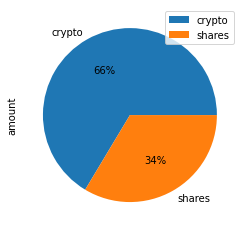

In [78]:
# Plot savings pie chart
df_savings.plot.pie(labels=['crypto', 'shares'], autopct='%.0f%%', subplots=True)

In [79]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings.iloc[:, 0].sum()
total_savings = round(total_savings, 2)

# Validate saving health
if total_savings > emergency_fund:
  print(f"Congratulations! You have enough money in this fund.")
elif total_savings == emergency_fund:
  print(f"You have exactly enough savings! Congratulations on reaching this financial goal.")
else:
  print(f"Almost there! You are {emergency_fund - total_savings} away from reaching this financial goal.")

Congratulations! You have enough money in this fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [80]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
yesterday = pd.Timestamp.now(tz="America/New_York") - pd.Timedelta(days=1)

start = (yesterday - pd.Timedelta(days=365*5)).strftime('%Y-%m-%d')
end = yesterday.strftime('%Y-%m-%d')

In [81]:
# Get 5 years' worth of historical data for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
df_stock_data = apca.get_bars(tickers, TimeFrame.Day, start, end, adjustment='raw').df
df_stock_data.index = pd.DatetimeIndex(df_stock_data.index.date, name='date')

df_stock_data = df_stock_data[['close', 'symbol']]
df_stock_data = pd.pivot_table(df_stock_data, values='close', columns='symbol', index=df_stock_data.index)

multi_index_columns = pd.MultiIndex.from_tuples(
  [(ticker, "close") for ticker in tickers]
)

df_stock_data.columns = multi_index_columns
df_stock_data

# Display sample data
df_stock_data.head()

,AGG,SPY
,close,close
date,,
2017-03-27,108.62,233.62
2017-03-28,108.37,235.32
2017-03-29,108.61,235.54
2017-03-30,108.41,236.29
2017-03-31,108.49,235.74


In [82]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyear = MCSimulation(
  portfolio_data = df_stock_data,
  weights = [.40,.60],
  num_simulation = 500,
  num_trading_days = 252*30
)

In [83]:
# Printing the simulation input data
df_stock_data.head()

,AGG,SPY
,close,close
date,,
2017-03-27,108.62,233.62
2017-03-28,108.37,235.32
2017-03-29,108.61,235.54
2017-03-30,108.41,236.29
2017-03-31,108.49,235.74


In [84]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999915,0.993396,1.000893,0.997651,0.996591,1.001568,1.006369,1.008179,0.998921,1.006168,...,1.002291,1.004116,0.994231,0.992670,1.011863,0.991672,1.011618,0.993095,0.997807,1.007210
2,1.002161,0.993670,0.991413,0.993197,1.004131,0.997756,1.004343,1.022022,0.991110,0.998987,...,1.012122,0.999046,0.995533,0.993024,0.999918,1.005581,1.014670,0.994992,0.999663,1.011536
3,0.994838,0.993614,0.984437,0.993151,1.000045,0.993716,1.009461,1.025457,0.993305,0.994929,...,1.004491,0.999771,0.999805,0.989597,0.994421,1.003186,1.004942,0.995837,0.980605,1.019898
4,0.992688,0.987050,0.980745,1.004982,0.997892,0.988596,1.014928,1.020302,1.006293,1.004124,...,0.997587,1.007098,1.005329,0.984126,1.006438,1.016152,1.010746,0.991824,0.978728,1.013357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,10.335640,5.746041,14.351703,11.504210,21.905373,16.171497,11.401362,25.671218,12.422583,10.071976,...,10.085888,11.473091,4.875356,30.681813,9.822055,21.574885,31.559233,14.321096,5.430343,7.896463
7557,10.227434,5.776501,14.388024,11.374967,22.007685,16.333780,11.380004,25.467999,12.322041,10.077285,...,10.020558,11.455762,4.843801,30.588773,9.930927,21.677745,31.578100,14.115051,5.404344,7.853582
7558,10.320541,5.788625,14.506181,11.374501,22.011026,16.208748,11.458490,25.477515,12.226046,10.067157,...,10.053088,11.493895,4.853454,30.250966,9.951750,21.454072,31.539763,14.097059,5.385085,7.824305
7559,10.236548,5.805383,14.430535,11.299880,21.873921,16.317084,11.445240,25.161101,12.353403,10.231225,...,10.147317,11.595112,4.832796,30.721646,10.041784,21.496288,31.482767,14.167340,5.344457,7.868879


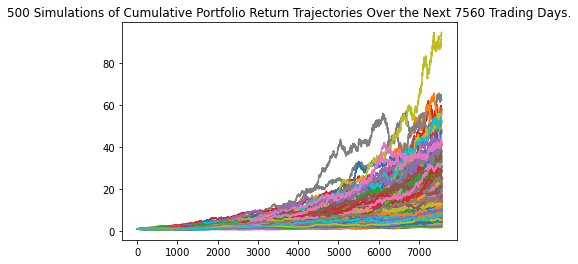

In [85]:
# Plot simulation outcomes
line_plot = MC_thirtyyear.plot_simulation()

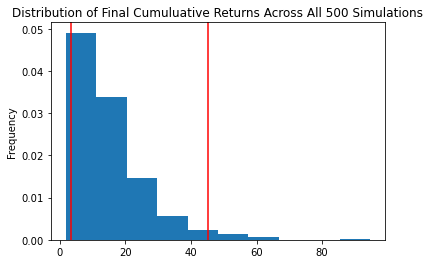

In [86]:
# Plot probability distribution and confidence intervals
dist_plot = MC_thirtyyear.plot_distribution()

### Retirement Analysis

In [87]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats = MC_thirtyyear.summarize_cumulative_return()

# Print summary statistics
print(summary_stats)

count           500.000000
mean             14.969798
std              11.042743
min               1.784919
25%               7.977302
50%              11.703391
75%              18.846154
max              94.661153
95% CI Lower      3.226438
95% CI Upper     45.327307
Name: 7560, dtype: float64


/Users/adam/fintech/api-homework/MCForecastTools.py:176: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [88]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(summary_stats[8]*initial_investment,2)
ci_upper = round(summary_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $64528.76 and $906546.14


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [89]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(summary_stats[8]*initial_investment,2)
ci_upper = round(summary_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${int(initial_investment)} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000 in the portfolio over the next 30 years will end within in the range of $96793.14 and $1359819.21


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [90]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear = MCSimulation(
  portfolio_data = df_stock_data,
  weights = [.40,.60],
  num_simulation = 500,
  num_trading_days = 252*5
)

In [91]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001244,0.996705,1.001758,1.004541,1.002673,0.996888,0.998392,0.994971,1.000390,1.007845,...,1.004143,1.002581,1.008521,1.006438,0.999996,0.993594,1.013476,0.994752,1.004095,1.007505
2,0.995560,0.993367,0.991949,1.013830,1.012451,1.001406,1.003796,0.988836,0.998404,0.996089,...,1.004512,1.002364,1.012611,1.019525,1.006167,0.987629,1.012305,0.989530,1.005538,1.005644
3,1.001701,0.988566,0.991807,1.014761,1.013148,1.013852,1.006581,0.992124,0.997213,1.000441,...,0.995536,1.002496,1.006416,1.023781,0.994985,0.996533,1.009864,0.994754,1.003613,1.017801
4,1.004559,0.978842,1.004808,1.014648,1.013674,1.004717,1.023399,0.989308,0.995004,1.003548,...,0.992391,1.002851,1.007761,1.020484,0.988683,0.994825,0.999586,0.993895,0.993358,1.010829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2.172563,1.911689,1.602559,1.262201,2.013763,1.453860,1.686211,1.526756,2.016555,1.727042,...,2.459537,2.048165,1.628508,1.351465,2.027652,1.633466,1.146815,1.258122,0.986756,1.740109
1257,2.197880,1.895963,1.609449,1.280008,2.024243,1.450012,1.683788,1.520622,2.048028,1.738243,...,2.438878,2.061353,1.612174,1.360645,2.024280,1.629517,1.148055,1.266357,0.989447,1.739281
1258,2.212457,1.887134,1.626219,1.283897,2.026157,1.444769,1.692359,1.489495,2.043211,1.747948,...,2.447298,2.072634,1.611500,1.358756,2.056869,1.636181,1.172453,1.266922,0.988453,1.743953
1259,2.227051,1.884807,1.622761,1.278424,2.012959,1.442056,1.671830,1.499598,2.065650,1.742528,...,2.429945,2.057213,1.589623,1.369353,2.045285,1.636789,1.180871,1.266259,0.993751,1.774099


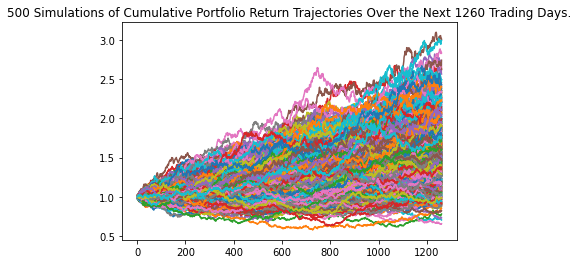

In [92]:
# Plot simulation outcomes
line_plot = MC_fiveyear.plot_simulation()

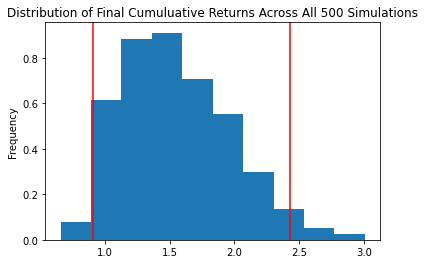

In [93]:
# Plot probability distribution and confidence intervals
dist_plot = MC_fiveyear.plot_distribution()

In [94]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats = MC_fiveyear.summarize_cumulative_return()

# Print summary statistics
print(summary_stats)

count           500.000000
mean              1.549670
std               0.418305
min               0.658614
25%               1.231625
50%               1.500086
75%               1.831437
max               3.007169
95% CI Lower      0.909675
95% CI Upper      2.428277
Name: 1260, dtype: float64


/Users/adam/fintech/api-homework/MCForecastTools.py:176: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [95]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(summary_stats[8]*initial_investment,2)
ci_upper_five = round(summary_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $54580.49 and $145696.6


### Ten Years Retirement Option

In [96]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear = MCSimulation(
  portfolio_data = df_stock_data,
  weights = [.40,.60],
  num_simulation = 500,
  num_trading_days = 252*10
)

In [97]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.992282,0.993692,1.014670,1.011356,1.004279,1.002519,0.997101,1.000377,1.002830,1.007828,...,0.998107,1.008275,0.998222,1.001664,0.999950,1.016434,0.993571,1.007712,1.000015,1.002166
2,0.994102,1.002772,1.006616,1.011518,0.995659,1.019044,0.994040,1.001099,0.991743,0.999916,...,0.992100,1.010155,0.995842,0.995772,0.996994,1.031415,0.980940,1.008955,1.008101,0.983466
3,0.995865,1.003965,1.007669,1.004295,0.996306,1.015465,0.993586,1.003728,1.005111,0.992696,...,0.973895,1.013986,0.996134,0.992786,1.000658,1.039415,0.980601,1.010528,1.001862,0.995922
4,1.003581,1.010695,1.009287,0.991435,0.999364,1.016360,0.998612,1.016738,1.004190,0.994835,...,0.978951,1.018954,1.013128,0.996216,0.986407,1.035958,0.987334,1.009481,1.004973,1.002290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.484505,3.222111,2.300287,2.232079,3.277797,2.097448,1.663997,2.302558,2.469775,1.088984,...,2.194585,1.239553,1.923432,3.864109,3.176541,1.916464,2.314113,1.275274,2.338218,2.529081
2517,1.491359,3.246861,2.298602,2.232247,3.233365,2.088025,1.675781,2.298041,2.459474,1.084048,...,2.172180,1.242841,1.920020,3.850463,3.176796,1.924068,2.330260,1.266371,2.338643,2.485548
2518,1.515094,3.227577,2.292050,2.239489,3.244354,2.093787,1.676709,2.319053,2.454198,1.082754,...,2.196192,1.257490,1.903931,3.858949,3.210531,1.908154,2.320914,1.276505,2.370129,2.452739
2519,1.522292,3.234396,2.273091,2.205396,3.259767,2.109216,1.688741,2.332155,2.438309,1.088963,...,2.199855,1.268175,1.914753,3.863239,3.208969,1.903850,2.318965,1.273455,2.380672,2.427885


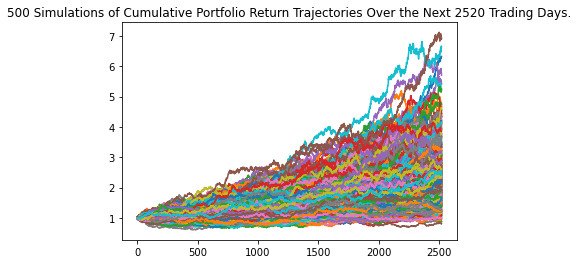

In [98]:
# Plot simulation outcomes
line_plot = MC_tenyear.plot_simulation()

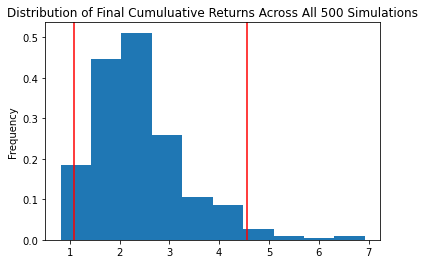

In [99]:
# Plot probability distribution and confidence intervals
dist_plot = MC_tenyear.plot_distribution()

In [100]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats = MC_tenyear.summarize_cumulative_return()

# Print summary statistics
print(summary_stats)

count           500.000000
mean              2.393586
std               0.926523
min               0.815938
25%               1.769405
50%               2.246864
75%               2.816061
max               6.922874
95% CI Lower      1.093825
95% CI Upper      4.551067
Name: 2520, dtype: float64


/Users/adam/fintech/api-homework/MCForecastTools.py:176: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [101]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(summary_stats[8]*initial_investment,2)
ci_upper_ten = round(summary_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $65629.52 and $273064.02
